# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $\mathcal{M}$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $t$. Usually, they are related following a nonlinear state-space model:
\begin{align}
  x(t) & = \mathcal{M}\left(x(t-\text{d}t)\right) + \eta(t)\\
  y(t) & = H x(t) + \epsilon(t)
\end{align}
with $\eta$ and $\epsilon$ independants zero-mean Gaussian noises with covariances $Q$ and $R$, respectively representing the model forecast error and the error of observation. Specification and tuning of these errors are important issues in data assimilation.

Here, we evaluate the performance of different methods to estimate the covariance matrices $Q$ and $R$ using the stochastic EnKF (for online estimation) and EnKS (for offline estimation):
- Expectation Maximization algorithm (noted EM-EnKS, see Dreano et al. 2017)
- Lag Innovation statistics (noted LI-EnKS, see Berry and Sauer 2013)
- Bayesian Inference method (noted BI-EnKF, see Stroud et al. 2017)
- Covariance Inflation technique (CI-EnKF, see Miyoshi 2011)

# IMPORT MODULES

Here, we import the different Python libraries and modules. Concerning the dynamical models, we provide two different implementations: a slow procedure in Python and a fast procedure in Fortran. In order to use the Fortran version, you need to compile the f90 files in the "models" folder ("l63_for.f90" and "l96_for.f90") using the command "f2py". You also need to download the "tqdm" library to display the progress bar (available at http://github.com/tqdm/).

In [167]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# L63 and L96 models using fortran (fast)
import models.l96f as mdl_l96

# L63 and L96 models using python (slow)
from models.L96 import l96_predict, l96_f, l96_jac

# data assimilation routines
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import _EKF, _EKS, EKS, EM_EKS
from algos.LI_EKS import LI_EKF, LI_EKS
from algos.CI_EKS import CI_EKF, CI_EKS
from algos.BI_EKF import BI_EKF
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# GENERATE LORENZ-96 DATA

Here, we perform an experiment with the 40-dimensional Lorenz-96 dynamical model. We generate data using $Q=0.1 I$ and $R=2 I$ using $\text{d}t=0.05$.

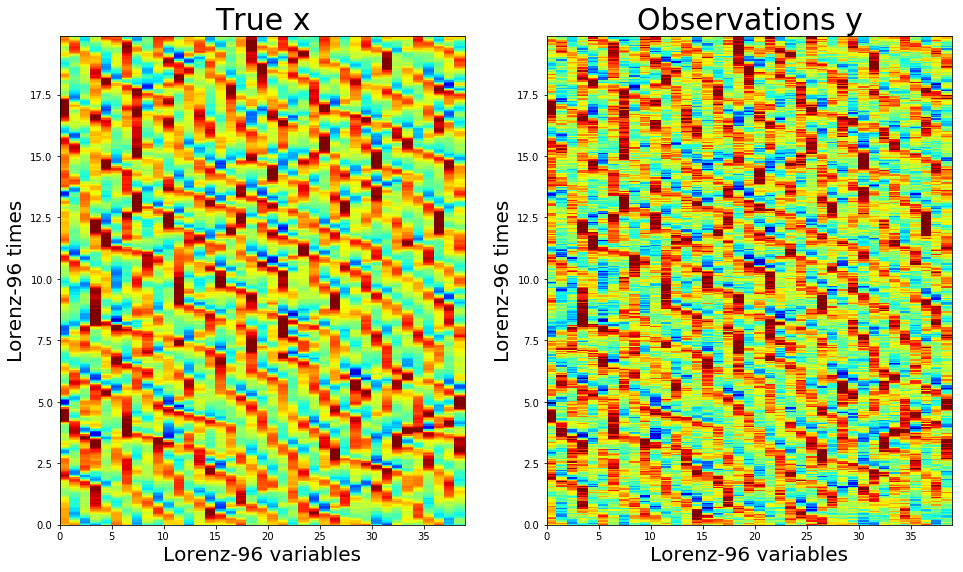

In [175]:
# random number generator
prng = numpy.random.RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
#f = lambda x: l96_predict(x,dt,F) # python version (slow)
fmdl=mdl_l96.M(dtcy=dt, force=F, nx=Nx);f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l96_jac(x, dt) # python version (slow)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = eye(Nx)

# size of the sequence
T = 10000 ### IMPORTANT
time = range(T+1)*array([dt])

# generate state
Q_true = eye(Nx) * .1
X_true = gen_truth(f, x0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1 ### IMPORTANT
R_true = eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

# plot state and observations (sample of 20 Lorenz-96 times)
[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);
pcolor(X[0:399,:], Y[0:399,:], X_true[:,0:399].T, cmap='jet')
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('True x', size=30)
subplot(1,2,2);
pcolor(X[0:399,:], Y[0:399,:], ma.masked_where(isnan(Yo[:,0:399].T),Yo[:,0:399].T), cmap='jet');
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('Observations y', size=30)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/x_y_L96.png', bbox_inches='tight')

Then, we compute the likelihood and RMSE using the true Q and R parameters.

In [162]:
from pytictoc import TicToc
t = TicToc() #create instance of class

t.tic() #Start timer

# background state
xb, B = climat_background(X_true)

# parameters
params = { 'observations'                 : Yo,
           'background_state'             : xb,
           'background_covariance'        : B,
           'model_noise_covariance'       : Q_true,
           'observation_noise_covariance' : R_true,
           'model_dynamics'               : f,
           'model_jacobian'               : jacF,
           'observation_operator'         : h,
           'observation_jacobian'         : jacH,
           'state_size'                   : Nx,
           'observation_size'             : No,
           'temporal_window_size'         : T,
           'true_state'                   : X_true,
           'inflation_factor'             : 1
          }

# function
res_EKS = EKS(params)

# extract outputs
loglik_true = res_EKS['loglikelihood']
RMSE_true = res_EKS['RMSE']

t.toc() #Time elapsed since t.tic()

Elapsed time is 9.300165 seconds.


# EM-EKS: Expectation Maximization algorithm (offline)

Here, we use the Expectation-Maximization algorithm to maximize the total likelihood of the state-space model. This code is attached to the publication from **Dreano et al. 2017**: "Estimating model error covariances in nonlinear state-space models using Kalman smoothing and the expectation-maximisation algorithm", *Quarterly Journal of the Royal Meteorological Society*.

In [229]:
# initial counditions and number of iterations
N_iter = 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True, ### IMPORTANT
           'inflation_factor'                         : 1 }

# function
res_EM_EKS = EM_EKS(params)

# extract outputs
Q_EM_EKS = res_EM_EKS['EM_model_noise_covariance']
R_EM_EKS = res_EM_EKS['EM_observation_noise_covariance']
loglik_EM_EKS=res_EM_EKS['loglikelihood']
RMSE_EM_EKS=res_EM_EKS['RMSE']

100%|██████████| 100/100 [20:07<00:00, 12.08s/it]


# LI-EKS: Lag Innovation statistics (offline)

Here, we use the lag innovation statistics (difference between consecutive innovations). This code is an extension of the method attached to the publication from **Berry and Sauer 2013**: "Adaptive ensemble Kalman filtering of non-linear systems", *Tellus A*.

In [164]:
# initial counditions and number of iterations
N_iter = 50
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_iterations'                            : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           'inflation_factor'                         : 1,
           'adaptive_parameter'                       : 25000 ### IMPORTANT
         }

# function
res_LI_EKS = LI_EKS(params)

# extract outputs
Q_LI_EKS = res_LI_EKS['LI_model_noise_covariance']
R_LI_EKS = res_LI_EKS['LI_observation_noise_covariance']
loglik_LI_EKS = res_LI_EKS['loglikelihood']
RMSE_LI_EKS = res_LI_EKS['RMSE']

100%|██████████| 100/100 [34:55<00:00, 20.96s/it]


# EM-EKS VS LI-EKS (offline)

Here, we compare the 2 offline methods EM-EKS and LI-EKS for the estimation of constant $Q$ and $R$ matrices.

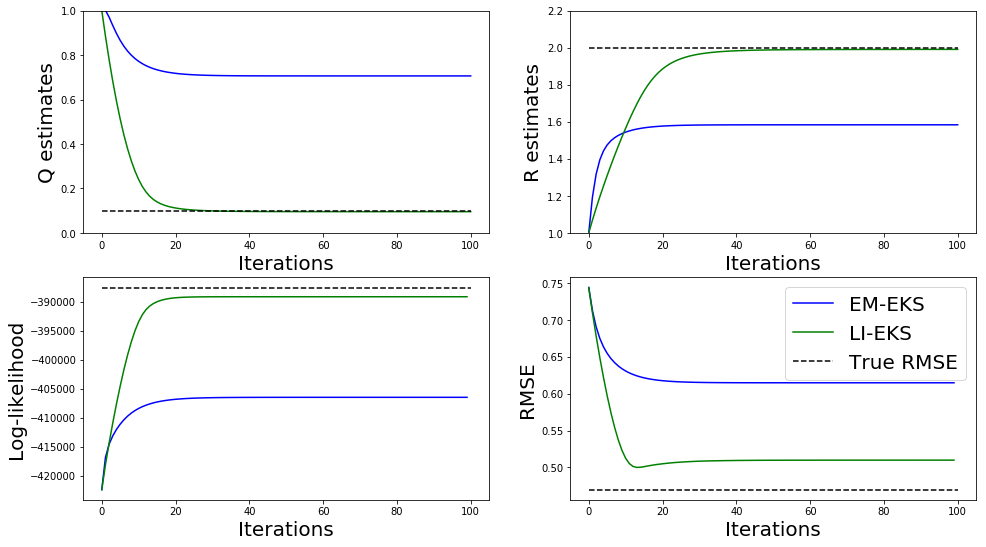

In [230]:
# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(trace(Q_EM_EKS)/Nx,'b')
line2,=plt.plot(trace(Q_LI_EKS)/Nx,'g')
line3,=plt.plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Q estimates', fontsize=20)
ylim([0,1])
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True Q'], fontsize=20)

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(trace(R_EM_EKS)/No,'b')
line2,=plt.plot(trace(R_LI_EKS)/No,'g')
line3,=plt.plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('R estimates', fontsize=20)
ylim([1,2.2])
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True R'], fontsize=20)

# plot log-likelihood
plt.subplot(2,2,3)
line1,=plt.plot(loglik_EM_EKS,'b')
line2,=plt.plot(loglik_LI_EKS,'g')
line3,=plt.plot((0,N_iter),(loglik_true,loglik_true),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Log-likelihood', fontsize=20)
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True log-lik'], fontsize=20)

# plot Root Mean Square Error
plt.subplot(2,2,4)
line1,=plt.plot(RMSE_EM_EKS,'b')
line2,=plt.plot(RMSE_LI_EKS,'g')
line3,=plt.plot((0,N_iter),(RMSE_true,RMSE_true),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True RMSE'], fontsize=20)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/L96_Q_R_offline.png', bbox_inches='tight')

# CI-EKS: Covariance Inflation technique (offline)

Here, we use the covariance inflation technique to account for understimated $P^f$ covariance matrix and estimate $R$ matrix. This code is from **Miyoshi 2011**: "The Gaussian approach to adaptive covariance inflation and its implementation with the local ensemble transform Kalman filter", *Monthly Weather Review*.

In [159]:
# initial counditions and number of iterations
N_iter = 5
lambda_init = 1
sigma2_R_init = 1

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_multiplicative_inflation'         : lambda_init,
           'initial_observation_noise_variance'       : sigma2_R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_iterations'                            : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'adaptive_parameter'                       : 20000 ### IMPORTANT
         }

# function
res_CI_EKS = CI_EKS(params)

# extract outputs
lambda_CI_EKS = res_CI_EKS['adaptive_multiplicative_inflation']
sigma2_R_CI_EKS = res_CI_EKS['adaptive_observation_noise_variance']
loglik_CI_EKS = res_CI_EKS['loglikelihood']
RMSE_CI_EKS = res_CI_EKS['RMSE']


  0%|          | 0/5 [00:00<?, ?it/s]
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/home/ptandeo/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ptandeo/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ptandeo/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:33: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean(E**2))
 20%|██        | 1/5 [00:15<01:03, 15.76s/it]/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
100%|██████████| 5/5 [01:18<00:00, 15.79s/it]


# LI-EKS: Lag Innovation statistics (online)

Here, we use the lag innovation statistics (difference between consecutive innovations). This code is an extension of the method attached to the publication from **Berry and Sauer 2013**: "Adaptive ensemble Kalman filtering of non-linear systems", *Tellus A*.

[ nan  nan  nan  nan  nan]


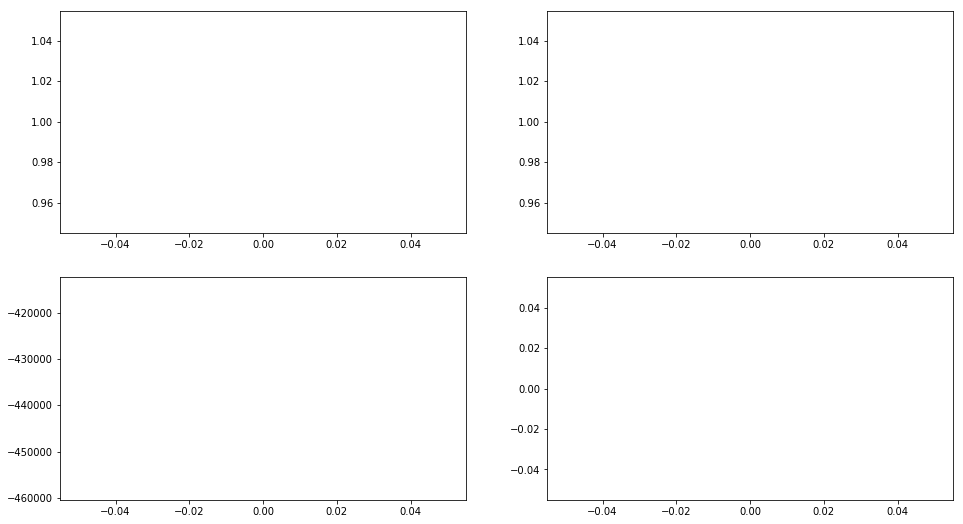

In [160]:
subplot(2,2,1);plot(lambda_CI_EKS)
subplot(2,2,2);plot(sigma2_R_CI_EKS)
subplot(2,2,3);plot(loglik_CI_EKS)
subplot(2,2,4);plot(RMSE_CI_EKS)
print(RMSE_CI_EKS)

In [154]:
# initial counditions 
lambda_init = 1.93
sigma2_R_init = 1.26

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_multiplicative_inflation'         : lambda_init,
           'initial_observation_noise_variance'       : sigma2_R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'adaptive_parameter'                       : 20000 ### IMPORTANT
         }

# function
res_CI_EKF = CI_EKF(params)

# extract outputs
lambda_CI_EKF = res_CI_EKF['adaptive_multiplicative_inflation']
sigma2_R_CI_EKF = res_CI_EKF['adaptive_observation_noise_variance']
loglik_CI_EKF = res_CI_EKF['loglikelihood']
RMSE_CI_EKF = res_CI_EKF['RMSE']

2.02187833382
1.34047594633


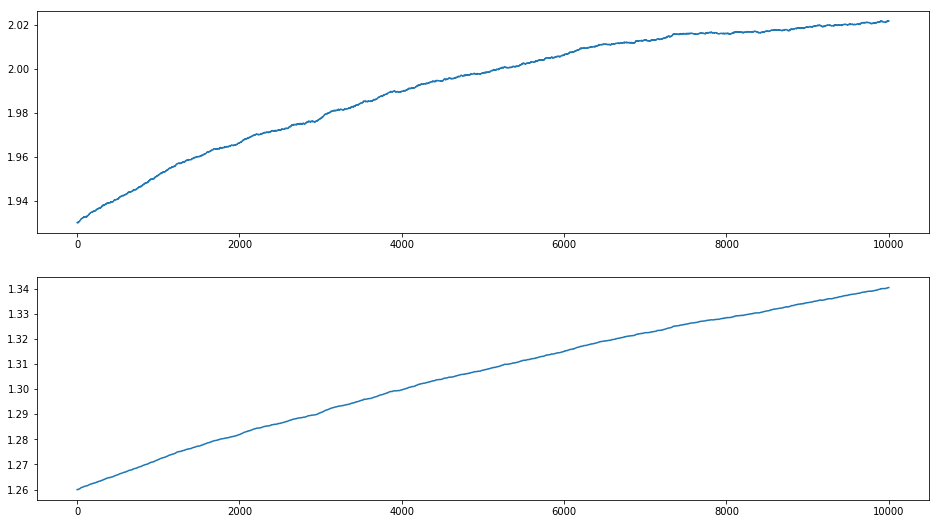

In [155]:
subplot(2,1,1);plot(lambda_CI_EKF);print(lambda_CI_EKF[-1])
subplot(2,1,2);plot(sigma2_R_CI_EKF);print(sigma2_R_CI_EKF[-1])

# LI-EKS: Lag Innovation statistics

Here, we use the lag innovation statistics (difference between consecutive innovations). This code is an extension of the method attached to the publication from **Berry and Sauer 2013**: "Adaptive ensemble Kalman filtering of non-linear systems", *Tellus A*.

In [24]:
# initial counditions
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           'inflation_factor'                         : 1,
           'adaptive_parameter'                       : 3000 ### IMPORTANT
         }

# function
res_LI_EKF = LI_EKF(params)

# extract outputs
Q_LI_EKF = res_LI_EKF['LI_model_noise_covariance']
R_LI_EKF = res_LI_EKF['LI_observation_noise_covariance']
loglik_LI_EKF = res_LI_EKF['loglikelihood']
RMSE_LI_EKF = res_LI_EKF['RMSE']

# CI-EnKS VS LI-EnKS (online methods)

Here, we compare the 2 online methods CI-EnKS and LI-EnKS for the estimation of constant $Q$ and $R$ matrices.

NameError: name 'lambda_CI_EKF' is not defined

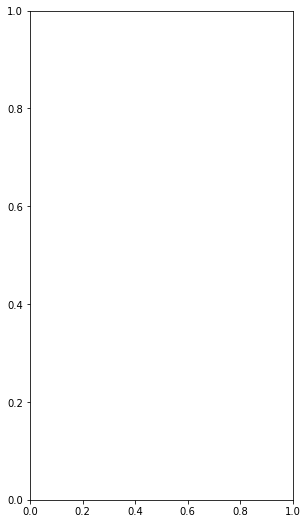

In [8]:
# plot inflation factor
subplot(1,3,1)
line1,=plt.plot(lambda_CI_EKF,'b')
line2,=plt.plot((0,T),(1,1),'--k')
plt.title('Multiplicative inflation estimates')
ylim([0,10])
plt.legend([line1, line2], ['CI-EKF', '$\lambda$=1'])

# plot trace of Q
plt.subplot(1,3,2)
line1,=plt.plot(trace(Q_LI_EKF)/Nx,'g')
line2,=plt.plot((0,T),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
ylim([0,1])
plt.legend([line1, line2], ['LI-EKS', 'True Q'])

# plot trace of R
subplot(1,3,3)
line1,=plt.plot(sigma2_R_CI_EKF,'b')
line2,=plt.plot(trace(R_LI_EKF)/No,'g')
line3,=plt.plot((0,T),(trace(R_true)/No,trace(R_true)/No),'--k')
plt.title('R estimates')
ylim([0,5])
plt.legend([line1, line2], ['CI-EKF', 'LI-EKF', 'True $\sigma^2_o$'])

# print log-likelihood
print('Log-likelihood (CI-EKF): ', loglik_CI_EKF)
print('Log-likelihood (LI-EKF): ', loglik_LI_EKF)
print('Log-likelihood (true): ', loglik_true)

# print Root Mean Square Error
print('RMSE (CI-EKF): ', RMSE_CI_EKF)
print('RMSE (LI-EKF): ', RMSE_LI_EKF)
print('RMSE (true): ', RMSE_true)

# BAYESIAN INFERENCE (ONLINE)

Here, we use the adaptive Bayesian inference for the estimation of the variance parameters of the dynamic error and observation error matrices $Q$ and $R$. This code is attached to the publication from **Stroud et al. 2017**: "A Bayesian adaptive ensemble Kalman filter for sequential state and parameter estimation", *Monthly Weather Review*.

In [14]:
### APPLY THE BAYESIAN INFERENCE USING EXTENDED KALMAN FILTER (BI-EKF)

sigma2_Q_init = 1
sigma2_R_init = 1

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_variance'             : sigma2_Q_init,
           'initial_observation_noise_variance'       : sigma2_R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'adaptive_parameter'                       : 50
         }

# function
res_BI_EKF = BI_EKF(params)

# extract outputs
sigma2_Q_BI_EKF = res_BI_EKF['adaptive_model_noise_variance']
sigma2_R_BI_EKF = res_BI_EKF['adaptive_observation_noise_variance']
loglik_BI_EKF = res_BI_EKF['loglikelihood']
RMSE_BI_EKF = res_BI_EKF['RMSE']
Xa_BI_EKF = res_BI_EKF['filtered_states']

subplot(1,2,1)
line1,=plt.plot(lambda_BI_EKF,'b')
line2,=plt.plot((0,T),(1,1),'--k')
plt.title('Multiplicative inflation estimates')
ylim([0,5])
plt.legend([line1, line2], ['BI-EKF', '$\lambda$=1'])

subplot(1,2,2)
line1,=plt.plot(sigma2_R_BI_EKF,'b')
line2,=plt.plot((0,T),(trace(R_true)/No,trace(R_true)/No),'--k')
plt.title('R estimates')
ylim([0,5])
plt.legend([line1, line2], ['BI-EKF', 'True $\sigma^2_o$'])

IndexError: tuple index out of range